<a href="https://colab.research.google.com/github/rohinirohi786-source/Electricity-Consumption/blob/main/Time_Series_Forecasting_of_Electricity_Consumption_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Advanced Multivariate Time Series Forecasting of Electricity Consumption Using Attention-Based Deep Learning Models

SETUP & INSTALL LIBRARIES (COLAB)

In [1]:
# Install TensorFlow in Colab
!pip install -q tensorflow
!pip install -q scikit-learn


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    LSTM,
    Dense,
    Dropout,
    Attention,
    LayerNormalization,
    MultiHeadAttention,
    Add
)
from tensorflow.keras.callbacks import EarlyStopping

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


STEP 1: LOAD DATASET (Colab Upload)

In [3]:
from google.colab import files
uploaded = files.upload()  # Select your DATASET.csv


Saving weather-energy-data-update.csv to weather-energy-data-update.csv


In [4]:
# Load CSV
df = pd.read_csv("weather-energy-data-update.csv")

# Convert datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Set datetime as index
df = df.set_index('Datetime')

# Check first 5 rows
df.head()


,kWh,hour,day_of_month,day_of_week,month,is_weekend,pressure_at_sea,precip_dur_past10min,wind_dir,wind_speed,temp_dew,pressure,visib_mean_last10min,temp_dry,humidity,cloud_cover,visibility
Datetime,,,,,,,,,,,,,,,,,
2018-11-01 00:00:00,0.247,0.0,1.0,3.0,11.0,0,1017.966667,0.0,115.166667,2.616667,5.900000,1011.083333,8150.00000,6.150000,98.333333,5.000000,7666.666667
2018-11-01 01:00:00,0.131,1.0,1.0,3.0,11.0,0,1017.750000,0.0,119.500000,2.733333,6.250000,1010.883333,13666.66667,6.833333,96.166667,44.166667,13333.333330
2018-11-01 02:00:00,0.132,2.0,1.0,3.0,11.0,0,1017.500000,0.0,121.500000,3.016667,5.950000,1010.600000,22416.66667,7.383333,90.833333,77.500000,22000.000000
2018-11-01 03:00:00,0.076,3.0,1.0,3.0,11.0,0,1017.366667,0.0,124.166667,3.700000,5.616667,1010.533333,31483.33333,7.766667,86.166667,95.000000,29666.666670
2018-11-01 04:00:00,0.061,4.0,1.0,3.0,11.0,0,1016.916667,0.0,117.666667,3.333333,5.516667,1010.100000,36266.66667,7.866667,85.000000,95.000000,34166.666670


STEP 2: MISSING VALUE HANDLING

In [5]:
# Interpolate using time
df = df.interpolate(method='time')

# Fill any remaining NaNs (edge cases)
df = df.fillna(method='bfill').fillna(method='ffill')

# Check missing values
print(df.isnull().sum())


kWh                     0
hour                    0
day_of_month            0
day_of_week             0
month                   0
is_weekend              0
pressure_at_sea         0
precip_dur_past10min    0
wind_dir                0
wind_speed              0
temp_dew                0
pressure                0
visib_mean_last10min    0
temp_dry                0
humidity                0
cloud_cover             0
visibility              0
dtype: int64


/tmp/ipython-input-3084330873.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')


STEP 3: FEATURE ENGINEERING

In [6]:
# Target column
TARGET_COL = 'kWh'

# If not already in dataset, create time features
# (your dataset already has some, we can keep them)
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

# Feature columns (exclude target)
feature_cols = [col for col in df.columns if col != TARGET_COL]
print("Feature columns:", feature_cols)


Feature columns: ['hour', 'day_of_month', 'day_of_week', 'month', 'is_weekend', 'pressure_at_sea', 'precip_dur_past10min', 'wind_dir', 'wind_speed', 'temp_dew', 'pressure', 'visib_mean_last10min', 'temp_dry', 'humidity', 'cloud_cover', 'visibility', 'dayofweek']


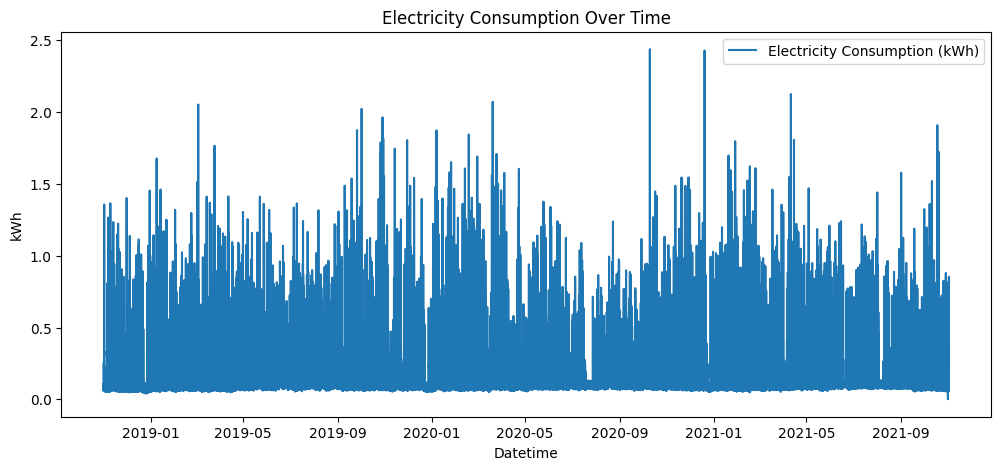

In [7]:
# Plot electricity consumption
plt.figure(figsize=(12,5))
plt.plot(df[TARGET_COL], label='Electricity Consumption (kWh)')
plt.title('Electricity Consumption Over Time')
plt.xlabel('Datetime')
plt.ylabel('kWh')
plt.legend()
plt.show()


STEP 4: TRAIN / VALIDATION / TEST SPLIT

In [8]:
train_size = int(len(df) * 0.7)
val_size   = int(len(df) * 0.85)

train = df.iloc[:train_size]
val   = df.iloc[train_size:val_size]
test  = df.iloc[val_size:]

print("Train shape:", train.shape)
print("Validation shape:", val.shape)
print("Test shape:", test.shape)


Train shape: (18429, 18)
Validation shape: (3949, 18)
Test shape: (3950, 18)


STEP 5: SCALING

In [9]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train)
val_scaled   = scaler.transform(val)
test_scaled  = scaler.transform(test)

# Convert back to DataFrame
train_scaled = pd.DataFrame(train_scaled, columns=df.columns, index=train.index)
val_scaled   = pd.DataFrame(val_scaled, columns=df.columns, index=val.index)
test_scaled  = pd.DataFrame(test_scaled, columns=df.columns, index=test.index)


STEP 6: SEQUENCE CREATION

In [10]:
SEQ_LEN = 24  # past 24 hours

def create_sequences(data, target_col, seq_len):
    X, y = [], []
    target_idx = data.columns.get_loc(target_col)

    for i in range(len(data) - seq_len):
        X.append(data.iloc[i:i+seq_len].values)
        y.append(data.iloc[i+seq_len, target_idx])

    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, TARGET_COL, SEQ_LEN)
X_val, y_val     = create_sequences(val_scaled, TARGET_COL, SEQ_LEN)
X_test, y_test   = create_sequences(test_scaled, TARGET_COL, SEQ_LEN)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (18405, 24, 18)
y_train shape: (18405,)


STEP 7: LSTM + ATTENTION MODEL

In [11]:
def build_lstm_attention_model(input_shape):
    inputs = Input(shape=input_shape)

    x = LSTM(64, return_sequences=True)(inputs)
    x = LSTM(64, return_sequences=True)(x)

    # Attention Layer
    attn_output = Attention()([x, x])

    x = tf.keras.layers.Flatten()(attn_output)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

lstm_attn_model = build_lstm_attention_model((X_train.shape[1], X_train.shape[2]))
lstm_attn_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 24, 64)    │     21,248 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 24, 64)    │     33,024 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 24, 64)    │          0 │ lstm_1[0][0],     │
│ (Attention)         │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1536)      │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │     49,184 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 103,489 (404.25 KB)

 Trainable params: 103,489 (404.25 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train LSTM + Attention
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm_attn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - loss: 0.0114 - mae: 0.0655 - val_loss: 0.0105 - val_mae: 0.0613
Epoch 2/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 39s 38ms/step - loss: 0.0062 - mae: 0.0480 - val_loss: 0.0093 - val_mae: 0.0565
Epoch 3/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - loss: 0.0060 - mae: 0.0461 - val_loss: 0.0095 - val_mae: 0.0534
Epoch 4/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 0.0056 - mae: 0.0451 - val_loss: 0.0086 - val_mae: 0.0528
Epoch 5/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - loss: 0.0057 - mae: 0.0443 - val_loss: 0.0091 - val_mae: 0.0521
Epoch 6/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - loss: 0.0052 - mae: 0.0424 - val_loss: 0.0083 - val_mae: 0.0505
Epoch 7/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - loss: 0.0056 - mae: 0.0441 - val_loss: 0.0084 - val_mae: 0.0519
Epoch 8/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - loss: 0.0056 - mae: 0.0446 - val_loss: 0.0087 - val_mae: 0.0552
Epoch 9/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 

STEP 8: TRANSFORMER MODEL

In [13]:
def build_transformer_model(input_shape, num_heads=4, ff_dim=64):
    inputs = Input(shape=input_shape)

    # Multi-Head Attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[1])(inputs, inputs)
    x = Add()([inputs, attn_output])
    x = LayerNormalization()(x)

    # Feed Forward
    ff_output = Dense(ff_dim, activation='relu')(x)
    ff_output = Dense(input_shape[1])(ff_output)
    x = Add()([x, ff_output])
    x = LayerNormalization()(x)

    x = tf.keras.layers.Flatten()(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

transformer_model = build_transformer_model((X_train.shape[1], X_train.shape[2]))
transformer_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 24, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 18)    │      5,418 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 18)    │          0 │ input_layer_1[0]… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 24, 18)    │         36 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 24, 64)    │      1,216 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 24, 18)    │      1,170 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 24, 18)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 18)    │         36 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 432)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │        433 │ flatten_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,309 (32.46 KB)

 Trainable params: 8,309 (32.46 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train Transformer
history_trans = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.0664 - mae: 0.1489 - val_loss: 0.0096 - val_mae: 0.0614
Epoch 2/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 0.0076 - mae: 0.0594 - val_loss: 0.0085 - val_mae: 0.0544
Epoch 3/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0065 - mae: 0.0529 - val_loss: 0.0110 - val_mae: 0.0657
Epoch 4/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0071 - mae: 0.0557 - val_loss: 0.0118 - val_mae: 0.0702
Epoch 5/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0068 - mae: 0.0526 - val_loss: 0.0076 - val_mae: 0.0541
Epoch 6/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0066 - mae: 0.0530 - val_loss: 0.0084 - val_mae: 0.0694
Epoch 7/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0063 - mae: 0.0520 - val_loss: 0.0078 - val_mae: 0.0491
Epoch 8/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0060 - mae: 0.0482 - val_loss: 0.0109 - val_mae: 0.0671
Epoch 9/50
576/576 ━━━━━━━━━━━━━━━━━━━━ 9s 1

STEP 9: EVALUATION

In [15]:
# Predict
y_pred_lstm = lstm_attn_model.predict(X_test)
y_pred_trans = transformer_model.predict(X_test)

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}")

print("LSTM + Attention Performance:")
evaluate(y_test, y_pred_lstm)

print("Transformer Performance:")
evaluate(y_test, y_pred_trans)


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
LSTM + Attention Performance:
MAE: 0.040, RMSE: 0.069
Transformer Performance:
MAE: 0.039, RMSE: 0.069


STEP 10: VISUALIZE PREDICTIONS

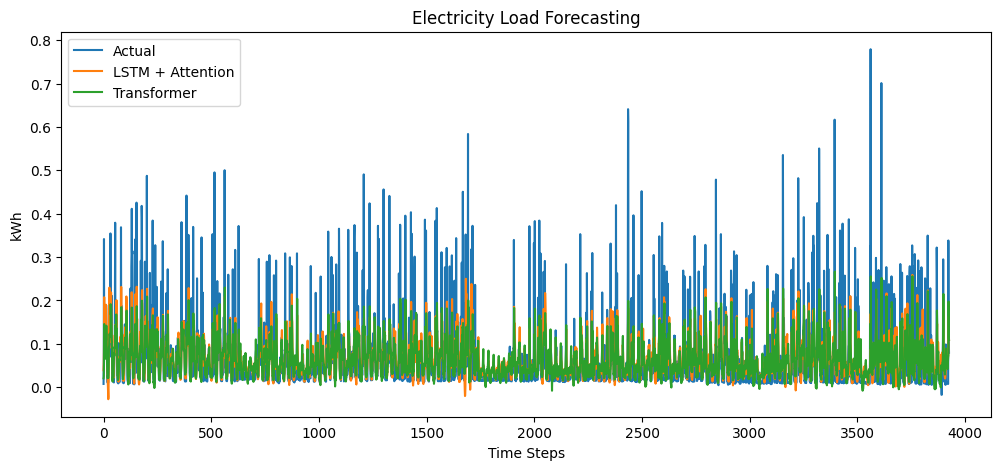

In [16]:
plt.figure(figsize=(12,5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_lstm, label='LSTM + Attention')
plt.plot(y_pred_trans, label='Transformer')
plt.title('Electricity Load Forecasting')
plt.xlabel('Time Steps')
plt.ylabel('kWh')
plt.legend()
plt.show()


STEP 11: MODEL COMPARISON (TABLE)

In [17]:
results = {
    "Model": ["LSTM + Attention", "Transformer"],
    "MAE": [
        mean_absolute_error(y_test, y_pred_lstm),
        mean_absolute_error(y_test, y_pred_trans)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_lstm)),
        np.sqrt(mean_squared_error(y_test, y_pred_trans))
    ]
}

comparison_df = pd.DataFrame(results)
comparison_df


,Model,MAE,RMSE
0,LSTM + Attention,0.039892,0.068522
1,Transformer,0.039288,0.068510
